# FPCMCI
This tutorial aims to explain how to perform a causal analysis by using the FPCMCI.
We will cover the following parts:
* 1 - Filtered - PCMCI
* 2 - Example
* 3 - FPCMCI vs PCMCI

<br>
First of all, we need to import the following packages:

In [24]:
from tigramite.independence_tests import GPDC
from fpcmci.CPrinter import CPLevel
from fpcmci.FPCMCI import FPCMCI
from fpcmci.preprocessing.data import Data
from fpcmci.preprocessing.subsampling_methods.Static import Static
from fpcmci.preprocessing.subsampling_methods.SubsamplingMethod import SubsamplingMethod
from fpcmci.preprocessing.subsampling_methods.WSDynamic import WSDynamic
from fpcmci.preprocessing.subsampling_methods.WSFFTStatic import WSFFTStatic
from fpcmci.preprocessing.subsampling_methods.WSStatic import WSStatic
from fpcmci.selection_methods.TE import TE, TEestimator
from fpcmci.basics.constants import LabelType
import numpy as np

from time import time
from datetime import timedelta

## 1 - Filtered - PCMCI

Filtered - PCMCI (FPCMCI) extends the state-of-the-art causal discovery method PCMCI by augmenting it with a feature-selection method based on Transfer Entropy. The algorithm, starting from a prefixed set of variables, identifies the correct subset of features and possible links between them which describe the observed process. Then, from the selected features and links, a causal model is built.

You can use two types of estimator:
- Gaussian, able to detect continuous and additive dependencies
- Kraskov, able to detect continuous and general dependencies

## 2 - Example
Here, a very simple example with a model composed by 5 equations.
- $X_0$ is linear dependent from $X_1$ and $X_3$;
- $X_1$ is only uniform noise. It is the confounder of $X_0$ and $X_2$;
- $X_2$ is non-linear dependent from $X_1$;
- $X_3$ is linear auto-dependent;
- $X_4$ is only uniform noise not connected to any other variables.

In [25]:
alpha = 0.05
min_lag = 1
max_lag = 1
    
np.random.seed(1)
T = 1000
N = 5
d = np.random.random(size = (T, N))
for t in range(max_lag, T):
    d[t, 0] += 2 * d[t-1, 1] + 3 * d[t-1, 2]
    d[t, 2] += 1.1 * d[t-1, 1]**2
    d[t, 3] += d[t-1, 3]
    
df = Data(d)

a causal model can be reconstructed by using the FPCMCI:



-------------------------------------------------------
Selecting relevant features among: ['X_0', 'X_1', 'X_2', 'X_3', 'X_4']
Selection method: Transfer Entropy
Significance level: 0.05
Max lag time: 1
Min lag time: 1
Data length: 1000

##
## Transfer Entropy analysis
##

## Target variable: X_0
(X_0 -1)             -->      (X_0)     |score: 0.032       |pval: 0.002        
(X_2 -1)             -->      (X_0)     |score: 1.481       |pval: 0.002        
(X_1 -1)             -->      (X_0)     |score: 0.839       |pval: 0.002        

## Target variable: X_1
(X_3 -1)             -->      (X_1)     |score: 0.003       |pval: 0.028        

## Target variable: X_2
(X_1 -1)             -->      (X_2)     |score: 0.392       |pval: 0.002        

## Target variable: X_3
(X_3 -1)             -->      (X_3)     |score: 6.222       |pval: 0.002        

## Target variable: X_4
no sources selected


-------------------------------------------------------
Running Causal Discovery Algorithm



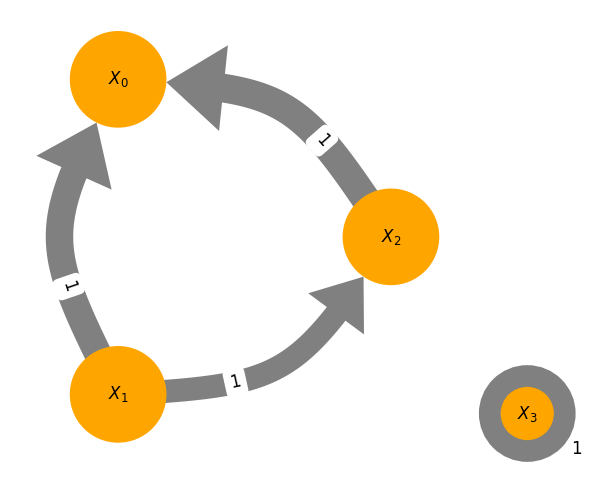

In [26]:
FS = FPCMCI(df, 
            alpha = alpha, 
            min_lag = min_lag, 
            max_lag = max_lag, 
            sel_method = TE(TEestimator.Gaussian), 
            val_condtest = GPDC(significance = 'analytic', gp_params = None),
            verbosity = CPLevel.DEBUG)
FS.run()
FS.dag(label_type = LabelType.Lag, node_layout = 'circular')

As you can see, since $X_4$ does not depend and does not affect any other variable, it has been removed. Moreover, by setting `neglect_only_autodep = True`, you can also neglect the variable that are auto-dependent but are not connectect to any other variables.



-------------------------------------------------------
Selecting relevant features among: ['X_0', 'X_1', 'X_2', 'X_3']
Selection method: Transfer Entropy
Significance level: 0.05
Max lag time: 1
Min lag time: 1
Data length: 1000

##
## Transfer Entropy analysis
##

## Target variable: X_0
(X_0 -1)             -->      (X_0)     |score: 0.032       |pval: 0.002        
(X_2 -1)             -->      (X_0)     |score: 1.481       |pval: 0.002        
(X_1 -1)             -->      (X_0)     |score: 0.839       |pval: 0.002        

## Target variable: X_1
(X_3 -1)             -->      (X_1)     |score: 0.003       |pval: 0.018        

## Target variable: X_2
(X_1 -1)             -->      (X_2)     |score: 0.392       |pval: 0.002        

## Target variable: X_3
(X_3 -1)             -->      (X_3)     |score: 6.222       |pval: 0.002        


-------------------------------------------------------
Running Causal Discovery Algorithm

##
## Step 1: PC1 algorithm with lagged conditions
#

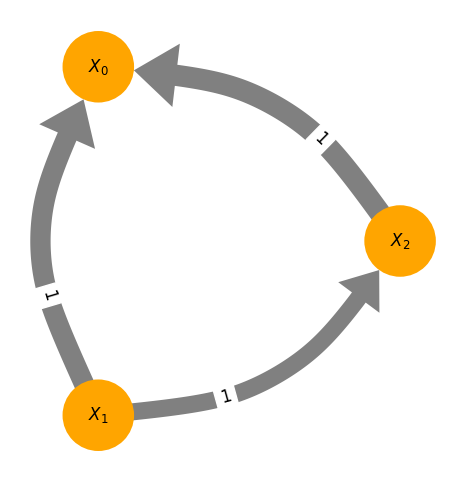

In [27]:
FS = FPCMCI(df, 
            alpha = alpha, 
            min_lag = min_lag, 
            max_lag = max_lag, 
            sel_method = TE(TEestimator.Gaussian), 
            val_condtest = GPDC(significance = 'analytic', gp_params = None),
            verbosity = CPLevel.DEBUG,
            neglect_only_autodep = True)
FS.run()
FS.dag(label_type = LabelType.Lag, node_layout = 'circular')

## 3 - FPCMCI vs PCMCI
Here, we compare the two algorithms, FPCMCI and PCMCI, on the same data under the point of view of executional time and accuracy of the causal model.
<br><br>
First of all, we need to generate data. We can do it as follows:

In [28]:
alpha = 0.05
min_lag = 1
max_lag = 2
    
np.random.seed(1)
T = 1500
N = 7
d = np.random.random(size = (T, N))
for t in range(max_lag, T):
    d[t, 0] += 2 * d[t-1, 1] + 3 * d[t-2, 3]
    d[t, 2] += 1.1 * d[t-1, 1]**2
    d[t, 3] += d[t-1, 3] * d[t-2, 2]
    d[t, 4] += d[t-2, 4] + d[t-2, 5] * d[t-1, 0]
        
df = Data(d)
   

Then, a causal model can be computed by using the FPCMCI:



-------------------------------------------------------
Selecting relevant features among: ['X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6']
Selection method: Transfer Entropy
Significance level: 0.05
Max lag time: 2
Min lag time: 1
Data length: 1500

##
## Transfer Entropy analysis
##

## Target variable: X_0
(X_0 -1)             -->      (X_0)     |score: 0.174       |pval: 0.002        
(X_0 -2)             -->      (X_0)     |score: 0.033       |pval: 0.002        
(X_3 -2)             -->      (X_0)     |score: 3.822       |pval: 0.002        
(X_1 -1)             -->      (X_0)     |score: 0.844       |pval: 0.002        

## Target variable: X_1
no sources selected

## Target variable: X_2
(X_1 -1)             -->      (X_2)     |score: 0.389       |pval: 0.002        

## Target variable: X_3
(X_3 -1)             -->      (X_3)     |score: 0.175       |pval: 0.002        
(X_3 -2)             -->      (X_3)     |score: 0.032       |pval: 0.002        
(X_2 -2)             -->

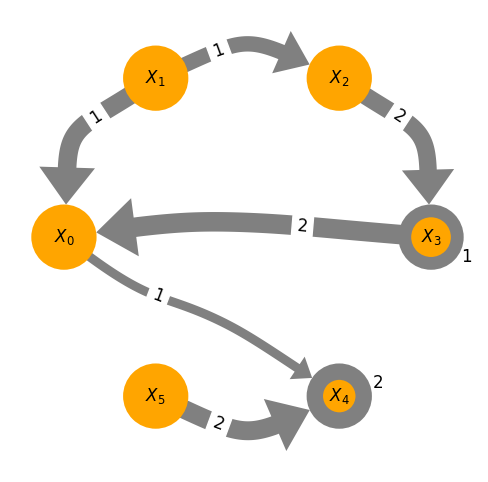

In [29]:
start = time()
FS = FPCMCI(df, 
            alpha = alpha, 
            min_lag = min_lag, 
            max_lag = max_lag, 
            sel_method = TE(TEestimator.Gaussian), 
            val_condtest = GPDC(significance = 'analytic', gp_params = None),
            verbosity = CPLevel.DEBUG)
    
selector_res = FS.run()
elapsed_FPCMCI = time() - start
print("FPCMCI executional time: " + str(timedelta(seconds = elapsed_FPCMCI)))
FS.dag(label_type = LabelType.Lag, node_layout = 'circular')

As you can see, $X_6$ has been removed because it does not depend and does not affect any other variable.
Now, we can perform the same analysis by using the PCMCI causal discovery algorithm:

Significance level: 0.05
Max lag time: 2
Min lag time: 1
Data length: 1500


-------------------------------------------------------
Running Causal Discovery Algorithm

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = gp_dc
tau_min = 1
tau_max = 2
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Variable $X_0$

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link ($X_0$ -1) --> $X_0$ (1/12):
    Subset 0: () gives pval = 0.00000 / val =  0.736
    No conditions of dimension 0 left.

    Link ($X_0$ -2) --> $X_0$ (2/12):
    Subset 0: () gives pval = 0.00000 / val =  0.570
    No conditions of dimension 0 left.

    Link ($X_1$ -1) --> $X_0$ (3/12):
    Subset 0: () gives pval = 0.00100 / val =  0.085
    No conditions of dimension 0 left.

    Link ($X_1$ -2) --> $X_0$ (4/12):
    Subset 0: () gives pval = 0.23200 / val =  0.046
    Non-significance detected.

    Link ($X

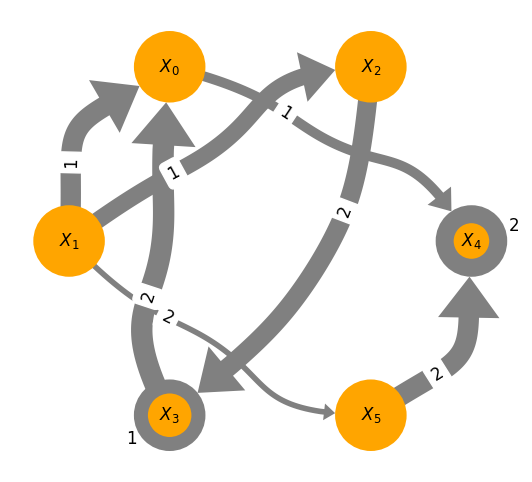

In [30]:
start = time()   
selector_res = FS.run_pcmci()
elapsed_PCMCI = time() - start
print("PCMCI executional time: " + str(timedelta(seconds = elapsed_PCMCI)))
FS.dag(label_type = LabelType.Lag, node_layout = 'circular')

FPCMCI executional time ~ 6min 30sec<br>
PCMCI executional time ~ 13min 25sec<br>
<br>
The comparison confirms that the FPCMCI results **faster** and **more accurate** than the PCMCI.